In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"


# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"



# Common imports
import numpy as np
import pandas as pd
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)



Creating the data models autoencoder folder

In [2]:
!mkdir -p data/models/autoencoder

saving_path = './data/models/autoencoder/'

## Reading the dataset

- df_ok: labels of ok gauges
- df_delta: labels of delta gauges
- df_ raw: raw data cointaining the full reading of each gauge

In [3]:
(saving_path+'prova_{}_strin{:02d}.csv').format(5,5)

'./data/models/autoencoder/prova_5_strin05.csv'

In [4]:
df_delta = pd.read_csv('df_delta.csv') # cointains labels for delta VG
df_ok = pd.read_csv('df_ok.csv')  #contains labels for ok VG

df_raw = pd.read_csv('df_raw.csv') ## contains full reading of each VG
df_raw = df_raw.set_index(['gauge_id','fillNumber'], drop=True)

df_labels = pd.concat([df_ok, df_delta], sort=False, axis=0)


df_VG = pd.merge(df_raw, df_labels, on =['gauge_id','fillNumber'])
df_VG = df_VG.set_index(['gauge_id','fillNumber'], drop=True)

## Removing categorical values
df_VG.y.replace(to_replace=['ok', 'delta'], value=[0, 1], inplace=True)

## Splitting the dataset in input and target
- X are the input features
- y is the target vector

X_train, X_valid, y_train, y_valid are the labeled instances

X_train_ae is the unlabeled dataset to train the autoencoder

In [5]:
print(df_raw.shape)
print(df_VG.shape)

(6323, 3000)
(278, 3001)


In [7]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, MaxAbsScaler, MinMaxScaler, RobustScaler


class RowScaler(BaseEstimator, TransformerMixin):
    def __init__(self, scaling_method='Standard'):
        self.scaling_options = ['Standard', 'MinMax', 'MaxAbs', 'Robust']
        assert (scaling_method in self.scaling_options), 'scaling_method:' + scaling_method + ' not in ' + str(self.scaling_options)
        self.scaling_method = scaling_method

        return None

    def fit(self, X, y=None):
        if self.scaling_method == 'Robust':
            self.scaler = RobustScaler()
        elif self.scaling_method == 'MinMax':
            self.scaler = MinMaxScaler()
        elif self.scaling_method == 'Standard':
            self.scaler = StandardScaler()
        elif self.scaling_method == 'MaxAbs':
            self.scaler = MaxAbsScaler()
        return self
    
    def transform(self, X, y=None):
        return self.scaler.fit_transform(X.transpose()).transpose()


In [8]:
from sklearn.model_selection import train_test_split

df_unlabeled = df_raw.drop(index=df_VG.index)
X_train_ae = np.array(df_unlabeled)
X = np.array(df_VG.iloc[:, :-1])
y = np.array(df_VG.iloc[:, -1])

scaler = RowScaler()

X_train_ae = scaler.fit_transform(X_train_ae)
X = scaler.fit_transform(X)

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, random_state=42)

print(X_train_ae.shape)
print(X_train.shape)
print(X_valid.shape)
print(y_train.shape)
print(y_valid.shape)

(6045, 3000)
(186, 3000)
(92, 3000)
(186,)
(92,)


In [9]:
n_dim = 3

encoder = keras.models.Sequential([
    keras.layers.Dense(3000, input_shape=[3000]),
    keras.layers.Dense(n_dim),
])

decoder = keras.models.Sequential([
    keras.layers.Dense(n_dim, input_shape=[n_dim]),
    keras.layers.Dense(3000),
])

stacked_ae = keras.models.Sequential([encoder, decoder])
stacked_ae.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 3)                 9012003   
_________________________________________________________________
sequential_1 (Sequential)    (None, 3000)              12012     
Total params: 9,024,015
Trainable params: 9,024,015
Non-trainable params: 0
_________________________________________________________________


In [10]:
stacked_ae.compile(loss='mse', optimizer='adam')
model_path = saving_path + 'stacked_pca_{:02d}_dim.h5'.format(n_dim)

if os.path.exists(model_path):
    stacked_ae = keras.models.load_model(model_path)
    print(model_path + ' already exist and has been loaded.')

checkpoint_cb = keras.callbacks.ModelCheckpoint(model_path, save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

./data/models/autoencoder/stacked_pca_03_dim.h5 already exist and has been loaded.


In [46]:
history = stacked_ae.fit(X_train_ae, X_train_ae, epochs=50,
                         validation_data=(X_train_ae, X_train_ae),
                         callbacks=[checkpoint_cb, early_stopping_cb])

Train on 6045 samples, validate on 6045 samples
Epoch 1/50
6045/6045 [==============================] - 23s 4ms/sample - loss: 0.4739 - val_loss: 0.3733
Epoch 2/50
6045/6045 [==============================] - 22s 4ms/sample - loss: 0.3665 - val_loss: 0.3639
Epoch 3/50
6045/6045 [==============================] - 23s 4ms/sample - loss: 0.3643 - val_loss: 0.3628
Epoch 4/50
6045/6045 [==============================] - 24s 4ms/sample - loss: 0.3629 - val_loss: 0.3631
Epoch 5/50
6045/6045 [==============================] - 22s 4ms/sample - loss: 0.3626 - val_loss: 0.3622
Epoch 6/50
6045/6045 [==============================] - 40s 7ms/sample - loss: 0.3626 - val_loss: 0.3632
Epoch 7/50
6045/6045 [==============================] - 26s 4ms/sample - loss: 0.3625 - val_loss: 0.3623
Epoch 8/50
6045/6045 [==============================] - 17s 3ms/sample - loss: 0.3631 - val_loss: 0.3645
Epoch 9/50
6045/6045 [==============================] - 16s 3ms/sample - loss: 0.3628 - val_loss: 0.3621
Epoch 1

In [11]:
history.history['loss']

NameError: name 'history' is not defined

## Analysing the reconstruction

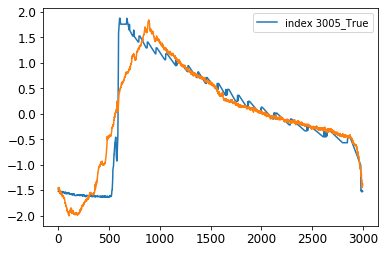

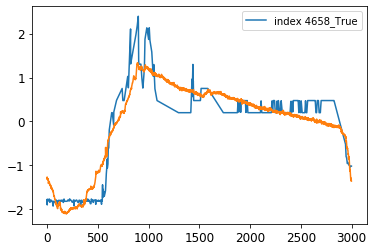

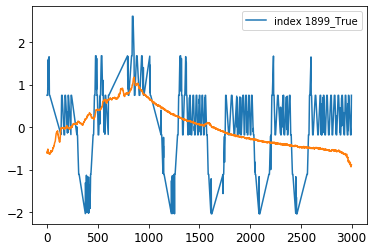

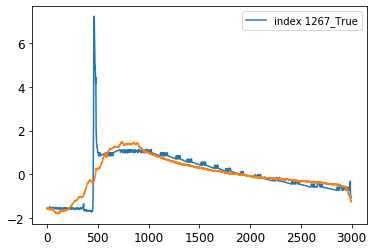

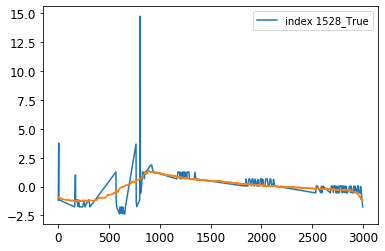

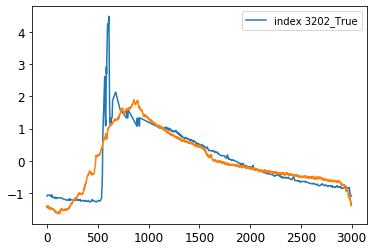

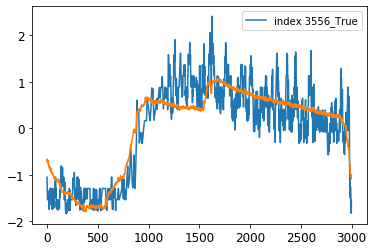

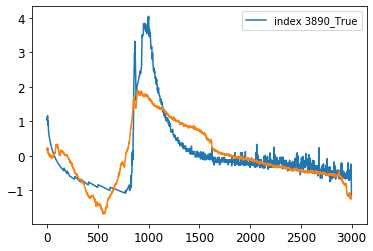

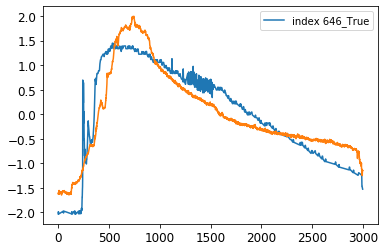

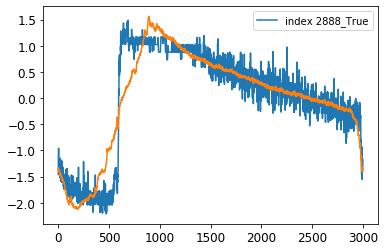

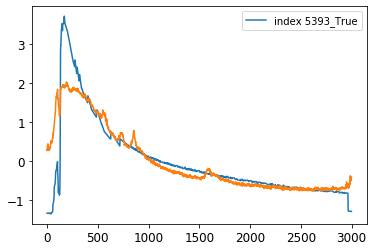

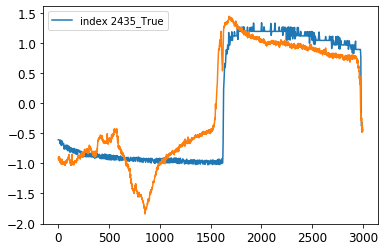

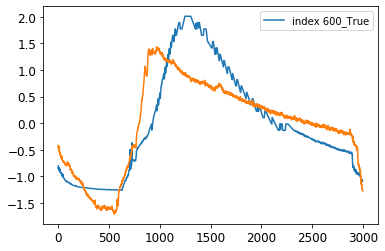

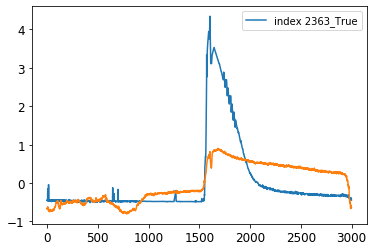

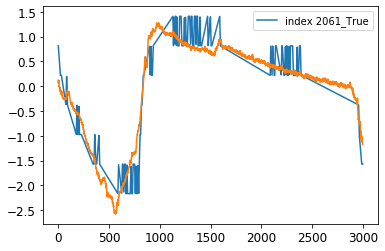

In [58]:
for index in np.random.randint(0,6045,15):
    X_pred = stacked_ae.predict(X_train_ae[[index]])
    plt.plot(range(3000), X_train_ae[index], label='index {}_True'.format(index))
    plt.plot(range(3000), X_pred[0])
    plt.legend()
    plt.show()

In [55]:
np.random.randint(0,10,5)

array([6, 3, 7, 4, 6])